# Sentiment Analysis

# PART 2

## Installs, Imports and Paths

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install -U scikit_learn
!pip install -U nltk
!pip install -U datasets
!pip install --upgrade tensorflow
!pip install scipy
!pip install --upgrade scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import random
import nltk
import tensorflow as tf
import os
import keras
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.constraints import MaxNorm
from datasets import load_dataset
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from google.colab import files
from scikeras.wrappers import KerasClassifier


stemmer = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
if not os.path.exists('./Sentiment-Analysis'):
  os.makedirs('./Sentiment-Analysis')
os.chdir('./Sentiment-Analysis')

## Data Preprocessing

### Dataset Loading

In [5]:
def remove(text, polarity, n):
    for _ in range(int(len(text)*n)):
        number = random.randrange(0,len(text))
        text.pop(number)
        polarity.pop(number)
    return

#importing the dataset
tweets = load_dataset("tweet_eval",'sentiment')

#create train/dev/test sets 
train = tweets['train']
dev = tweets['validation']
test = tweets['test']

x_train = train['text']
x_val = dev['text'] 
x_test = test['text']

y_train = train['label'] 
y_val = dev['label']
y_test = test['label']

#removing big parts because of too many data
#remove(x_train, y_train, 0.9)
#remove(x_val, y_val, 0.9)
#remove(x_test, y_test, 0.9)

print("Training Data Size: ", len(x_train))
print("Evaluation Data Size: ", len(x_val))
print("Test Data Size: ", len(x_test))


  0%|          | 0/3 [00:00<?, ?it/s]

Training Data Size:  45615
Evaluation Data Size:  2000
Test Data Size:  12284


### Heuristic for text-classification

In [6]:
total_size = []
for sent in x_train:
  internal_c = 0
  for word in sent:
    internal_c += 1
  total_size.append(internal_c)

sum = 0
for i in range(len(total_size)):
  sum += total_size[i]

mean = sum/len(total_size)

print(len(x_train))
print(mean)
print(len(x_train)/mean)

45615
106.93285103584347
426.57611349677785


### Data Cleaning Custom (faster)

In [7]:
def preProcess(x):
  document = []
  counter1 = 0
  for row in x:
      document.append(x[counter1])
      counter1 += 1


  for i in range(len(document)):
      # Extract text from Emojis and Emoticons
      # document[counter] = convert_emojis_to_word(i)

      # Remove non-word (special) characters such as punctuation, numbers etc
      document[i] = re.sub(r'\W', ' ', document[i])

      # Remove all single characters
      document[i] = re.sub(r'\s+[a-zA-Z]\s+', ' ', document[i])

      # Substitute multiple spaces with single space
      document[i] = re.sub(r'\s+', ' ', document[i], flags=re.I)

      # Convert to Lowercase
      document[i] = document[i].lower()

      # Split the document based on whitespaces (--> List of words)
      document[i] = document[i].split()

      # Lemmatization
      document[i] = [stemmer.lemmatize(word) for word in document[i]]

      # Reconstruct the document by joining the words on each whitespace
      document[i] = ' '.join(document[i])
      x[i] = document[i]

  return x


x_train_tokenized = preProcess(x_train)
x_val_tokenized = preProcess(x_val)
x_test_tokenized = preProcess(x_test)

### Data Cleaning Spacy (works a bit better)

In [8]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer') 

def tokenize_samples(samples):
  
  tokenized_samples = []
  for i in range(len(samples)):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip():  
          tokens.append(tok.text.replace('"',"'").strip())
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(x_train)
X_val_tokenized = tokenize_samples(x_val)
X_test_tokenized = tokenize_samples(x_test)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### TF-IDF Feature Extraction

In [9]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 3),
    max_features = 10000,
    min_df = 0.0001,
    max_df = 0.25,
    # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    sublinear_tf = True,
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - test)

# Spacy
x_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
x_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
x_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

# Custom
#x_train_tfidf = vectorizer.fit_transform(x_train_tokenized)
#x_val_tfidf = vectorizer.transform(x_val_tokenized)
#x_test_tfidf = vectorizer.transform(x_test_tokenized)

print('Shape of training data: {}'.format(x_train_tfidf.shape))
print('Shape of evaluation data: {}\n'.format(x_val_tfidf.shape))
print('Shape of test data: {}\n'.format(x_test_tfidf.shape))

print(x_val_tfidf[0, :])  # Sparce matrix --> Saves only the cells which are not zero

Shape of training data: (45615, 10000)
Shape of evaluation data: (2000, 10000)

Shape of test data: (12284, 10000)

  (0, 8771)	0.34681042615895413
  (0, 7821)	0.28970430393967495
  (0, 5814)	0.196184062957143
  (0, 4894)	0.32607629660635
  (0, 2281)	0.2872329701779469
  (0, 2275)	0.4361992771936199
  (0, 2274)	0.3174960235572627
  (0, 2273)	0.29709933609597977
  (0, 2025)	0.33299647352625855
  (0, 729)	0.279730274324458


### Label Binarization

In [10]:
lb = LabelBinarizer()
target_list_dict = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
target_list_name = ['Positive', 'Neutral', 'Negative']
target_list = ['0', '1', '2']

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_val_1_hot = lb.transform([target_list[x] for x in y_val])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))

y_train_1_hot[0]: [0 0 1]


### Dimensionality Reduction

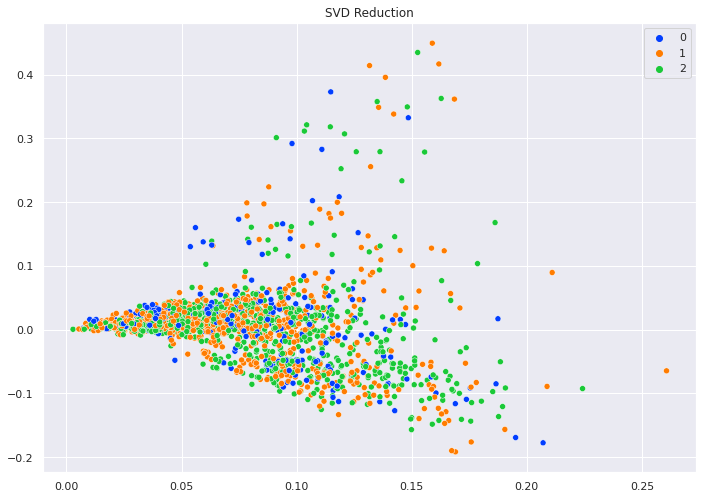

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 3)

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=1000, random_state=4321)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_val_svd = svd.transform(x_val_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

plt.figure()
plt.title('SVD Reduction')
sns.scatterplot(x=x_val_svd[:, 0], y=x_val_svd[:, 1], hue=y_val, legend='full', palette=palette)
plt.show(block=False)

### Callback Function

In [12]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average='micro')
        _val_recall = recall_score(val_targ, val_predict,average='micro')
        _val_precision = precision_score(val_targ, val_predict,average='micro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

## MLP

In [19]:
with tf.device('/device:GPU:0'):
  mlp_model = Sequential()
  mlp_model.add(Dense(512, input_dim=x_train_svd.shape[1] , activation='tanh'))
  mlp_model.add(keras.layers.BatchNormalization())
  mlp_model.add(Dropout(0.3))
  mlp_model.add(Dense(256,  activation='tanh', kernel_constraint=MaxNorm(2.0)))
  mlp_model.add(Dropout(0.3))
  mlp_model.add(Dense(len(target_list),  activation='softmax'))

  print(mlp_model.summary())
  
  #Configures the model for training.
  #CategoricalCrossentropy: Computes the crossentropy loss between the labels and predictions.
  mlp_model.compile(
      loss ='categorical_crossentropy',
      optimizer= RMSprop(learning_rate=0.001),
      metrics=["accuracy"]
      )

  if not os.path.exists('./my_MLP_checkpoint'):
    os.makedirs('./my_MLP_checkpoint')

  # Callback to save the Keras model or model weights at some frequency.  
  mlp_callbacks = [
    keras.callbacks.ModelCheckpoint(
    './my_MLP_checkpoint/weights.hdf5',
    monitor = 'val_accuracy',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)
  ]

  history = mlp_model.fit(
      x_train_svd, 
      y_train_1_hot,
      validation_data=(x_val_svd, y_val_1_hot),
      batch_size = 64,
      epochs = 8,
      shuffle=True,
      callbacks = mlp_callbacks
      )

  print(f"Test Accuracy: {mlp_model.evaluate(x_test_svd, y_test_1_hot)[1]:.5f}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               512512    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 771       
                                                      

### Learning Curves

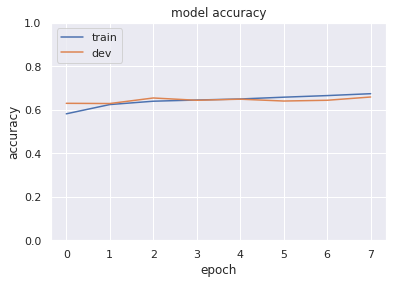

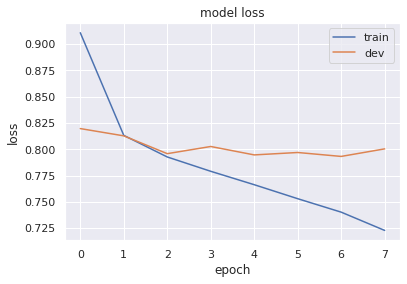

In [20]:
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.ylim(0,1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

### Model Assessment

In [22]:
with tf.device('/device:GPU:0'):

  mlp_model = Sequential()
  mlp_model.add(Dense(512, input_dim=x_train_svd.shape[1] , activation='tanh'))
  mlp_model.add(keras.layers.BatchNormalization())
  mlp_model.add(Dropout(0.3))
  mlp_model.add(Dense(256,  activation='tanh', kernel_constraint = MaxNorm(2.0)))
  mlp_model.add(Dropout(0.3))
  mlp_model.add(Dense(len(target_list),  activation='softmax'))
  
  # Load weights from the pre-trained model
  mlp_model.load_weights("./my_MLP_checkpoint/weights.hdf5")
  mlp_model.compile(
      loss='categorical_crossentropy',
      optimizer=RMSprop(learning_rate=0.001),
      metrics=["accuracy"]
      )

yhat_probs = mlp_model.predict(x_train_svd, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_train_f1_score = f1_score(y_train, yhat_classes, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

yhat_probs = mlp_model.predict(x_val_svd, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_val_f1_score = f1_score(y_val, yhat_classes, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(m_val_f1_score*100))

yhat_probs = mlp_model.predict(x_test_svd, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_test_f1_score = f1_score(y_test, yhat_classes, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

Train f1-score: 69.43% 

Evaluation f1-score: 60.40% 

Test f1-score: 52.07% 



### Precision, Recall, AUC, ROC-AUC

In [23]:
def calculateFinalResults(x, y):

  # predict probabilities for test set
  yhat_probs = mlp_model.predict(x, verbose=0)
  # predict crisp classes for test set
  yhat_classes = np.argmax(yhat_probs, axis=1)


  train_precision_score = precision_score(y, yhat_classes, average = None)
  train_recall_score = recall_score(y, yhat_classes, average = None)
  train_f1_score = f1_score(y, yhat_classes, average = None)


  m_train_precision_score = precision_score(y, yhat_classes, average = 'macro')
  m_train_recall_score = recall_score(y, yhat_classes, average = 'macro')
  m_train_f1_score = f1_score(y, yhat_classes, average = 'macro')


  m_train_roc_auc_score = roc_auc_score(y, yhat_probs, multi_class= 'ovr', average = 'macro')


  classes = [0, 1, 2]
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = mlp_model.predict(x, verbose=0) # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
        ['Positive', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
        ['Neutral', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
        ['Negative', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
        ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table


print("MLP ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
train_mlp = calculateFinalResults(x_train_svd, y_train)
%store train_mlp

print("The evaluation results: \n")
val_mlp = calculateFinalResults(x_val_svd, y_val)
%store val_mlp

print("The test results: \n")
test_mlp = calculateFinalResults(x_test_svd, y_test)
%store test_mlp

MLP ---------------------------------------------------------------------------------------------------------

The training results: 

╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.743       │ 0.478    │ 0.582 │ 0.902 │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.709       │ 0.79     │ 0.747 │ 0.848 │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.75        │ 0.758    │ 0

### Hyper Parameter Tuning for the MLP

In [24]:
from keras.optimizers import Adam, SGD, RMSprop

with tf.device('/device:GPU:0'):
  
  def nn_model(activation = 'relu', learning_rate = 0.01, neurons = 512, optimizer = 'Adam', dropout = 0.5, kernel_constraint= 3.0):
    mlp_model = Sequential()
    mlp_model.add(Dense(neurons, input_dim=x_train_svd.shape[1] , activation=activation))
    mlp_model.add(keras.layers.BatchNormalization())
    mlp_model.add(Dropout(dropout))
    mlp_model.add(Dense(neurons/2,  activation='relu', kernel_constraint=MaxNorm(kernel_constraint)))
    mlp_model.add(Dropout(dropout))
    mlp_model.add(Dense(len(target_list),  activation='softmax'))

    mlp_model.load_weights("./my_MLP_checkpoint/weights.hdf5")
    mlp_model.compile(loss='categorical_crossentropy', optimizer=tune_lr(optimizer, learning_rate), metrics=["accuracy"])

    return mlp_model

  def tune_lr(optimizer, learning_rate):
    optimizerDict = {'Adam': Adam(lr=learning_rate), 'SGD': SGD(lr=learning_rate),'RMSprop': RMSprop(lr=learning_rate)}
    result = optimizerDict[optimizer]

    return result

  activation = ['softmax', 'relu', 'tanh']
  learning_rate = [0.001, 0.01, 0.1]
  optimizer = ['Adam', 'SGD', 'RMSprop']
  batch_size = [64, 128, 256]
  epochs = [8, 10, 12, 15, 17]
  kernel_constraint = [1.0, 2.0, 3.0]
  dropout = [0.1, 0.3, 0.5]
  neurons = [1024, 512, 256]
  param_grid = dict(epochs = epochs, activation = activation, learning_rate = learning_rate, neurons = neurons, optimizer = optimizer, dropout = dropout, kernel_constraint = kernel_constraint, batch_size = batch_size)
  clf = KerasClassifier(build_fn = nn_model, epochs = epochs, verbose = 2, activation = activation, learning_rate = learning_rate, neurons = neurons,
                        optimizer = optimizer, dropout = dropout, kernel_constraint = kernel_constraint, batch_size = batch_size)
  mlp_model = RandomizedSearchCV(estimator= clf, cv = 5, param_distributions = param_grid, n_jobs=-1, verbose = 2, random_state=1234)

  mlp_model.fit(x_val_svd, y_val_1_hot)


print("Best estimator \n", mlp_model.best_estimator_)
print("Best score \n", mlp_model.best_score_)
print("Best params \n", mlp_model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/usr/local/lib/python3.8/dist-packages/scikeras/wrappers

Epoch 1/8


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 - 1s - loss: 0.8990 - accuracy: 0.6060 - 999ms/epoch - 62ms/step
Epoch 2/8
16/16 - 0s - loss: 0.7164 - accuracy: 0.6935 - 229ms/epoch - 14ms/step
Epoch 3/8
16/16 - 0s - loss: 0.6140 - accuracy: 0.7480 - 221ms/epoch - 14ms/step
Epoch 4/8
16/16 - 0s - loss: 0.5367 - accuracy: 0.7830 - 229ms/epoch - 14ms/step
Epoch 5/8
16/16 - 0s - loss: 0.4485 - accuracy: 0.8270 - 241ms/epoch - 15ms/step
Epoch 6/8
16/16 - 0s - loss: 0.3961 - accuracy: 0.8480 - 249ms/epoch - 16ms/step
Epoch 7/8
16/16 - 0s - loss: 0.3202 - accuracy: 0.8860 - 253ms/epoch - 16ms/step
Epoch 8/8
16/16 - 0s - loss: 0.2782 - accuracy: 0.8990 - 229ms/epoch - 14ms/step
Best estimator 
 KerasClassifier(
	model=None
	build_fn=<function nn_model at 0x7f967825b820>
	warm_start=False
	random_state=None
	optimizer=RMSprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=8
	activation=tanh
	learning_rate=0.001
	neurons=512
